## 1. Import libraries <a class="anchor" id="2"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
from tqdm import tqdm
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns
import nltk
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
#from sklearn.metrics.classification import accuracy_score, log_loss
# from sklearn.feature_extraction.text import Tfiall_dataVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
#from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
#from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier
from IPython.display import Image

from nltk.corpus import stopwords
from string import punctuation
from gensim import corpora, models, similarities 

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, log_loss
from sklearn.decomposition import PCA
from sklearn import tree
from lightgbm import LGBMClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier


import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

['textcol', 'textcol-test', 'cancerdata', 'models', 'textcol-new', 'bertdata', 'bert-final', 'bertdata1']


## 2. Download data <a class="anchor" id="3"></a>




In [2]:
data_variants = pd.read_csv('../input/cancerdata/training_variants')
data_text =pd.read_csv("../input/cancerdata/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
test_variants = pd.read_csv('../input/cancerdata/test_variants')
test_text =pd.read_csv("../input/cancerdata/test_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
cleaned_text_data = pd.read_csv('../input/textcol-new/textcol_new.csv')
cleaned_test_text_data = pd.read_csv('../input/textcol-test/textcol_test.csv')

In [3]:
all_data = pd.merge(data_variants, data_text,on='ID', how='left')
all_data.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [4]:
all_test = pd.merge(test_variants, test_text,on='ID', how='left')

In [5]:
print('There are {} rows and {} columns in train'.format(all_data.shape[0],all_data.shape[1]))
print('There are {} rows and {} columns in test'.format(all_test.shape[0],all_test.shape[1]))

There are 3321 rows and 5 columns in train
There are 5668 rows and 4 columns in test


In [6]:
del test_text
del test_variants
del data_variants
#del data_text

## 3. EDA <a class="anchor" id="4"></a>

In [7]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
 4   TEXT       3316 non-null   object
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


### Class distribution

In [8]:
all_data['Class'].value_counts()

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

Text(0.5, 1.0, 'Data count by Class')

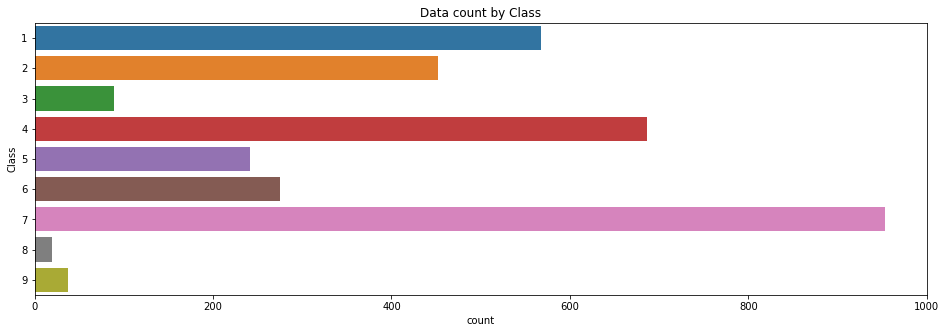

In [9]:
plt.figure(figsize=(16,5))
sns.countplot(y='Class',data=all_data)
plt.gca().xaxis.tick_bottom()
plt.title('Data count by Class')

### Common words in text

In [10]:
def create_corpus(data):
    corpus=[]
    
    for x in data.dropna(subset=['TEXT'])['TEXT'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [11]:
stop=list(stopwords.words('english'))
stop.extend(['The','the','In','also','fig','Figure','et','al.,','al', 'figure','also', 'et '])

In [12]:
corpus=create_corpus(all_data)

counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]

for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

<AxesSubplot:>

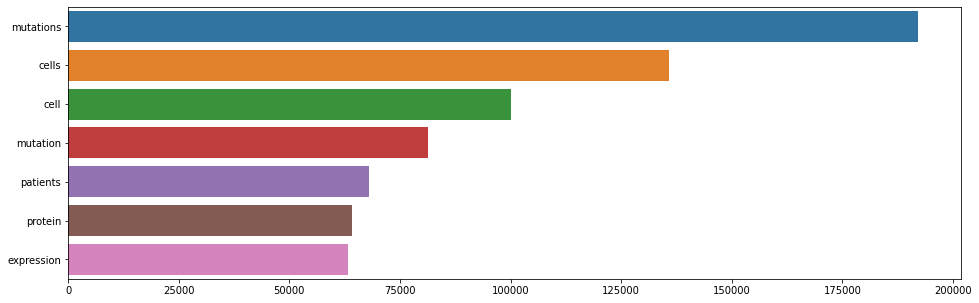

In [13]:
plt.figure(figsize=(16,5))
sns.barplot(x=y,y=x)

### Common stopwords in text

In [14]:
most=counter.most_common()
x_stop=[]
y_stop=[]

for word,count in most[:20]:
    if (word in stop) :
        x_stop.append(word)
        y_stop.append(count)

<AxesSubplot:>

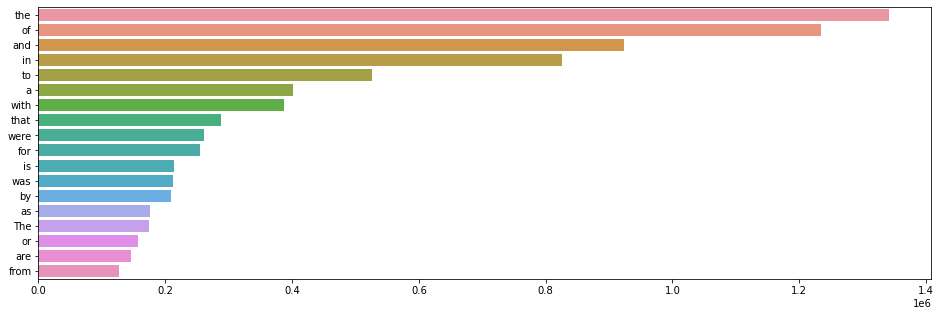

In [15]:
plt.figure(figsize=(16,5))
sns.barplot(x=y_stop,y=x_stop)

### Preprocessing and Cleaning of text

In [16]:
avg = 0
for i in all_data.index:
    if i in all_data[(all_data['TEXT'].isnull())].index:
        continue
    else:
        avg+=len(all_data['TEXT'][i].split(' '))
print('Average number of words in each text:',avg/3316)

Average number of words in each text: 9588.824788902291


In [17]:
def initial_clean(text):
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text


def remove_stop_words(text):
    return [word for word in text if word not in stop]

lemmatizer = WordNetLemmatizer()
def stem_words(text):
    try:
        text = [lemmatizer.lemmatize(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    if type(text) is not float:
        return ' '.join(stem_words(remove_stop_words(initial_clean(text))))
    else:
        return text

In [18]:
from tqdm import tqdm
tqdm.pandas(desc="my bar!")
k = all_data['TEXT'].progress_apply(apply_all)
all_data['TEXT'] = k
k.to_csv('./textcol_new.csv')
del k

my bar!: 100%|██████████| 3321/3321 [10:41<00:00,  5.18it/s]


In [19]:
cleaned_text_data = pd.read_csv('./textcol_new.csv')

In [20]:
print("cleaned: \n",cleaned_text_data['TEXT'][1][:257])
print("\n")
print("orignal: \n",all_data['TEXT'][1][:324])

cleaned: 
 abstract background non-small cell lung cancer nsclc heterogeneous group disorder number genetic proteomic alteration c-cbl e3 ubiquitin ligase adaptor molecule important normal homeostasis cancer determined genetic variation c-cbl relationship receptor tyr


orignal: 
 abstract background non-small cell lung cancer nsclc heterogeneous group disorder number genetic proteomic alteration c-cbl e3 ubiquitin ligase adaptor molecule important normal homeostasis cancer determined genetic variation c-cbl relationship receptor tyrosine kinase egfr met functionality nsclc method finding using arch


In [21]:
all_data['TEXT'] = cleaned_text_data['TEXT']
all_test['TEXT'] = cleaned_test_text_data['TEXT']

In [22]:
del cleaned_text_data
del cleaned_test_text_data

### N-gram analysis

##### We will do a bigram (n=2) analysis over the medical text. Let's check the most common bigrams in text.

In [23]:
corpus=create_corpus(all_data)

In [24]:
def get_top_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [25]:
top_bigrams=get_top_bigrams(all_data.dropna(subset=['TEXT'])['TEXT'])[:10]

<AxesSubplot:>

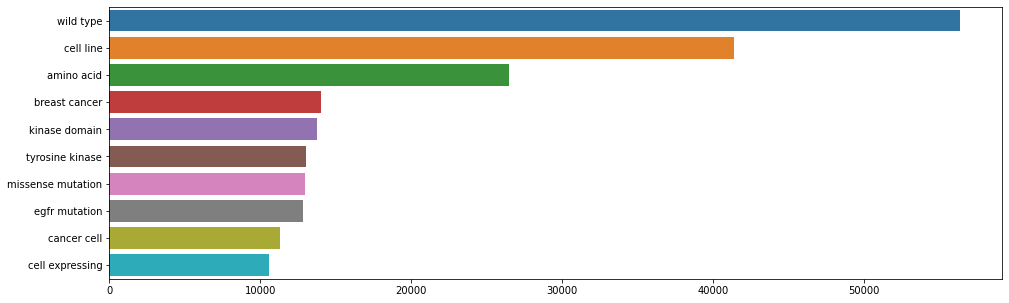

In [26]:
plt.figure(figsize=(16,5))
x,y=map(list,zip(*top_bigrams))
sns.barplot(x=y,y=x)

##### We will do a trigram (n=3) analysis over the medical text. Let's check the most common trigrams in text.

In [27]:
def get_top_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [28]:
top_trigrams=get_top_trigrams(all_data.dropna(subset=['TEXT'])['TEXT'])[:10]

<AxesSubplot:>

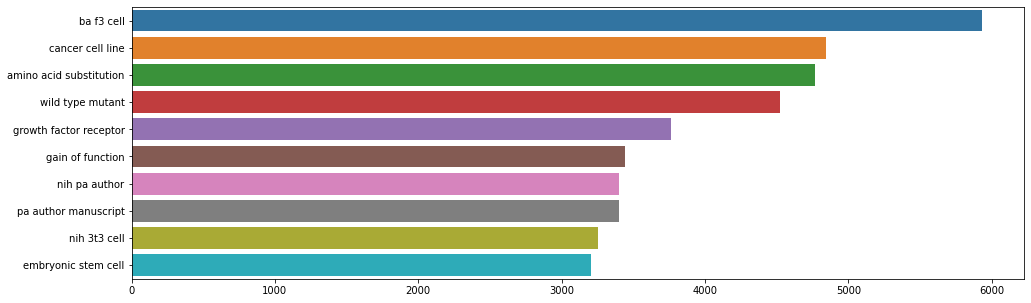

In [29]:
plt.figure(figsize=(16,5))
x,y=map(list,zip(*top_trigrams))
sns.barplot(x=y,y=x)

### Missing Value imputation

In [30]:
def LDA(gen, var):
    h = all_data[(all_data['Gene']==gen) | (all_data['Variation']==var)]['TEXT'].values
    corpus = [x for x in h if str(x) != 'nan']
    stoplist = stopwords.words('english') + list(punctuation)
    texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    tfidf = models.TfidfModel(corpus)
    corpus_tfiall_data = tfidf[corpus] 
    total_topics = 2
    lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
    corpus_lda = lda[corpus_tfiall_data]
    k = lda.show_topics(total_topics,100)
    return k
def final_text(gen,var):
    h = LDA(gen,var)
    reg = re.compile('"(.*?)"')
    ans = reg.findall(h[0][1])
    ans1 = reg.findall(h[1][1])
    ans.extend(ans1)
    fin = ' '.join(ans)
    return fin

for i in tqdm(all_data.loc[all_data['TEXT'].isnull()].index):
    all_data['TEXT'][i] = final_text(all_data['Gene'][i], all_data['Variation'][i])
for i in tqdm(all_test.loc[all_test['TEXT'].isnull()].index):
    all_test['TEXT'][i] = final_text(all_test['Gene'][i], all_test['Variation'][i])

100%|██████████| 1/1 [00:05<00:00,  5.20s/it]


In [31]:
all_data.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
TEXT         0
dtype: int64

In [32]:
del all_test

## 4. WordCloud <a class="anchor" id="6"></a>



In [33]:
string = data_text['TEXT'].dropna().to_list()
string = ' '.join(string)

In [34]:
%%time
from wordcloud import WordCloud, STOPWORDS
# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', 
                      collocations=False, stopwords = STOPWORDS).generate(string)

CPU times: user 57.1 s, sys: 1.1 s, total: 58.2 s
Wall time: 59.1 s


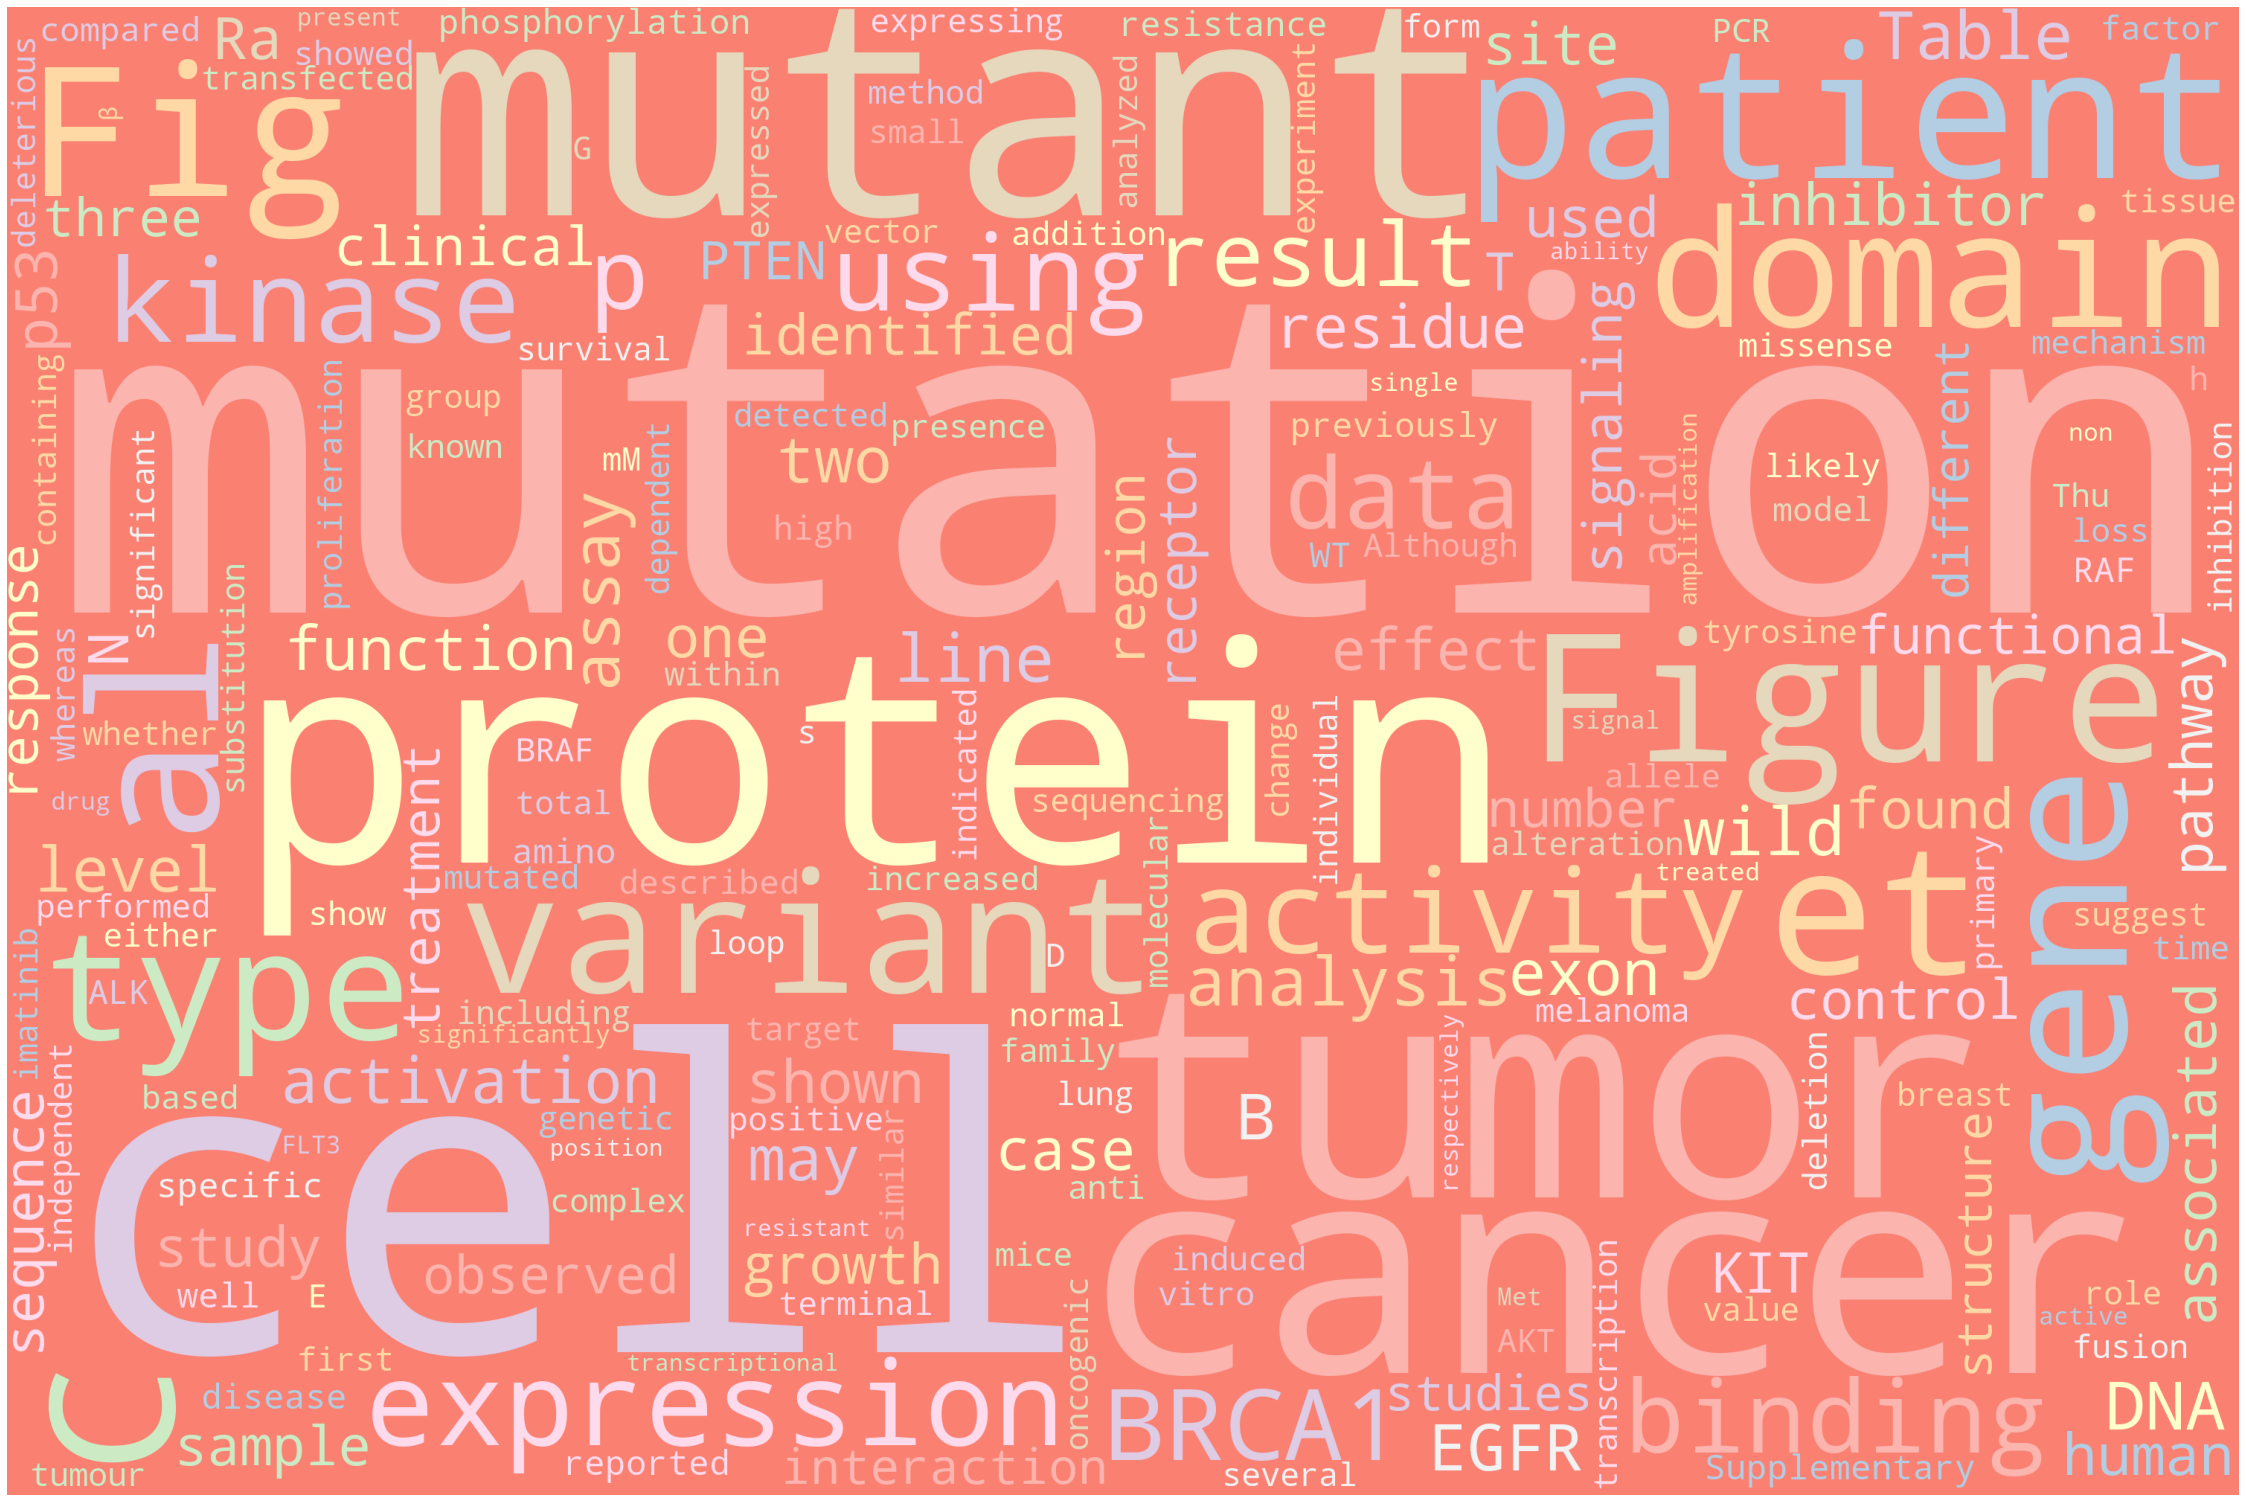

In [35]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off");
    
plot_cloud(wordcloud)

In [36]:
del string

## 5. Splitting dataset into Train, Test and Validation set<a class="anchor" id="6"></a>



In [37]:
y_true = all_data['Class'].values
X_train, test_df, y_train, y_test = train_test_split(all_data, y_true, stratify = y_true, test_size=0.2)

In [38]:
train_df, cv_df, y_train, y_cv = train_test_split(X_train,y_train,stratify = y_train, test_size=0.2 )

In [39]:
print('Data points in train data:', train_df.shape[0])
print('Data points in test data:', test_df.shape[0])
print('Data points in cross validation data:', cv_df.shape[0])

Data points in train data: 2124
Data points in test data: 665
Data points in cross validation data: 532


## 6. Word Embedding <a class="anchor" id="8"></a>


### Gene

In [40]:
vectorizer = TfidfVectorizer()
train_gene_feature_onehotCoding =  vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding  =  vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding    =  vectorizer.transform(cv_df['Gene'])

### Variant

In [41]:
train_variation_feature_onehotCoding =  vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding  =  vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding    =  vectorizer.transform(cv_df['Variation'])

### Text

In [42]:
text_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [43]:
del vectorizer

### Stacking all the 3 vectorized forms and making dataframes

In [44]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

## 7. Log Loss evaluation for feature importance <a class="anchor" id="8"></a>


In [45]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/rand_probs.sum())[0])

cv_log_loss = round(log_loss(y_cv,cv_predicted_y, eps=1e-15),2)

print("Log loss on Cross Validation Data using Random Model",cv_log_loss)

test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/rand_probs.sum())[0])
test_log_loss = round(log_loss(y_test,test_predicted_y, eps=1e-15),2)

print("Log loss on Test Data using Random Model",test_log_loss)

Log loss on Cross Validation Data using Random Model 2.5
Log loss on Test Data using Random Model 2.55


In [46]:
def LoglossWithFeat(train_feat_hotencode,cv_feat_hotencode):
    clf = SGDClassifier(alpha=0.1, penalty='l2', loss='log', random_state=42)
    clf.fit(train_feat_hotencode, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_feat_hotencode, train_y)
    predict_y = sig_clf.predict_proba(cv_feat_hotencode)
    return log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)

In [47]:
print("Log loss for Gene feature:",LoglossWithFeat(train_gene_feature_onehotCoding, cv_gene_feature_onehotCoding))
print("Log loss for Text feature:", LoglossWithFeat(train_text_feature_onehotCoding, cv_text_feature_onehotCoding))
print("Log loss for Variant feature:", LoglossWithFeat(train_variation_feature_onehotCoding, cv_variation_feature_onehotCoding))


Log loss for Gene feature: 1.4390740755321065
Log loss for Text feature: 1.4413129416916066
Log loss for Variant feature: 1.7309063497267128


In [48]:
del train_gene_feature_onehotCoding,train_variation_feature_onehotCoding
del test_gene_feature_onehotCoding,test_variation_feature_onehotCoding
del cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding
del train_gene_var_onehotCoding, train_text_feature_onehotCoding
del test_gene_var_onehotCoding, test_text_feature_onehotCoding
del cv_gene_var_onehotCoding, cv_text_feature_onehotCoding

## 8. Modelling <a class="anchor" id="8"></a>


In [49]:
eval_dict = {}

### Naive Bayes

In [50]:
%%time
clf = MultinomialNB(alpha=0.1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs_train = sig_clf.predict(train_x_onehotCoding)    
sig_clf_probs_test = sig_clf.predict(test_x_onehotCoding)    
sig_clf_probs_cv = sig_clf.predict(cv_x_onehotCoding)    
sig_clf_probs_train_l = sig_clf.predict_proba(train_x_onehotCoding)    
sig_clf_probs_test_l = sig_clf.predict_proba(test_x_onehotCoding)    
sig_clf_probs_cv_l = sig_clf.predict_proba(cv_x_onehotCoding)    

CPU times: user 1.41 s, sys: 0 ns, total: 1.41 s
Wall time: 1.41 s


In [51]:
print(classification_report(train_y,sig_clf_probs_train))
print(classification_report(test_y,sig_clf_probs_test))
print(classification_report(cv_y,sig_clf_probs_cv))
eval_dict['Naive Bayes'] = log_loss(train_y, sig_clf_probs_train_l)

del clf, sig_clf, sig_clf_probs_train, sig_clf_probs_test, sig_clf_probs_cv, sig_clf_probs_train_l, sig_clf_probs_test_l, sig_clf_probs_cv_l

              precision    recall  f1-score   support

           1       0.87      0.80      0.84       363
           2       0.82      0.90      0.85       289
           3       0.50      0.79      0.61        57
           4       0.94      0.81      0.87       439
           5       0.55      0.79      0.65       155
           6       0.80      0.86      0.83       176
           7       0.92      0.85      0.88       609
           8       0.00      0.00      0.00        12
           9       0.80      1.00      0.89        24

    accuracy                           0.83      2124
   macro avg       0.69      0.76      0.71      2124
weighted avg       0.85      0.83      0.83      2124

              precision    recall  f1-score   support

           1       0.57      0.57      0.57       114
           2       0.49      0.57      0.53        91
           3       0.37      0.56      0.44        18
           4       0.78      0.56      0.65       137
           5       0.41 

### Random forest

In [52]:
%%time
clf = RandomForestClassifier(n_estimators=1500, max_depth = 10)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs_train = sig_clf.predict(train_x_onehotCoding)    
sig_clf_probs_test = sig_clf.predict(test_x_onehotCoding)    
sig_clf_probs_cv = sig_clf.predict(cv_x_onehotCoding)    
sig_clf_probs_train_l = sig_clf.predict_proba(train_x_onehotCoding)    
sig_clf_probs_test_l = sig_clf.predict_proba(test_x_onehotCoding)    
sig_clf_probs_cv_l = sig_clf.predict_proba(cv_x_onehotCoding)    

CPU times: user 15min 55s, sys: 831 ms, total: 15min 56s
Wall time: 15min 59s


In [53]:
print(classification_report(train_y,sig_clf_probs_train))
print(classification_report(test_y,sig_clf_probs_test))
print(classification_report(cv_y,sig_clf_probs_cv))
eval_dict['Random Forest'] = log_loss(train_y, sig_clf_probs_train_l)

del clf, sig_clf, sig_clf_probs_train, sig_clf_probs_test, sig_clf_probs_cv, sig_clf_probs_train_l, sig_clf_probs_test_l, sig_clf_probs_cv_l

              precision    recall  f1-score   support

           1       0.86      0.91      0.88       363
           2       0.97      0.86      0.91       289
           3       0.70      0.40      0.51        57
           4       0.83      0.97      0.89       439
           5       0.95      0.39      0.55       155
           6       0.97      0.65      0.78       176
           7       0.82      0.98      0.90       609
           8       1.00      1.00      1.00        12
           9       1.00      0.79      0.88        24

    accuracy                           0.86      2124
   macro avg       0.90      0.77      0.81      2124
weighted avg       0.87      0.86      0.85      2124

              precision    recall  f1-score   support

           1       0.59      0.54      0.57       114
           2       0.61      0.51      0.55        91
           3       0.64      0.39      0.48        18
           4       0.64      0.72      0.68       137
           5       0.50 

### Stochastic Gradient Descent Classifier

In [54]:
%%time
clf = SGDClassifier(class_weight='balanced', alpha=0.001, penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs_train = sig_clf.predict(train_x_onehotCoding)    
sig_clf_probs_test = sig_clf.predict(test_x_onehotCoding)    
sig_clf_probs_cv = sig_clf.predict(cv_x_onehotCoding)  
sig_clf_probs_train_l = sig_clf.predict_proba(train_x_onehotCoding)    
sig_clf_probs_test_l = sig_clf.predict_proba(test_x_onehotCoding)    
sig_clf_probs_cv_l = sig_clf.predict_proba(cv_x_onehotCoding)    

CPU times: user 18 s, sys: 3.71 s, total: 21.7 s
Wall time: 15.9 s


In [55]:
print(classification_report(train_y,sig_clf_probs_train))
print(classification_report(test_y,sig_clf_probs_test))
print(classification_report(cv_y,sig_clf_probs_cv))
eval_dict['Logistic Regression with weightbalanced'] = log_loss(train_y, sig_clf_probs_train_l)

del clf, sig_clf, sig_clf_probs_train, sig_clf_probs_test, sig_clf_probs_cv, sig_clf_probs_train_l, sig_clf_probs_test_l, sig_clf_probs_cv_l

              precision    recall  f1-score   support

           1       0.88      0.93      0.90       363
           2       0.97      0.91      0.94       289
           3       0.83      0.53      0.65        57
           4       0.92      0.94      0.93       439
           5       0.84      0.63      0.72       155
           6       0.88      0.88      0.88       176
           7       0.91      0.99      0.95       609
           8       1.00      0.83      0.91        12
           9       1.00      0.92      0.96        24

    accuracy                           0.91      2124
   macro avg       0.91      0.84      0.87      2124
weighted avg       0.91      0.91      0.90      2124

              precision    recall  f1-score   support

           1       0.62      0.66      0.64       114
           2       0.67      0.45      0.54        91
           3       0.50      0.44      0.47        18
           4       0.72      0.72      0.72       137
           5       0.60 

### Decision Tree

In [56]:
%%time
clf = tree.DecisionTreeClassifier()
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs_train = sig_clf.predict(train_x_onehotCoding)    
sig_clf_probs_test = sig_clf.predict(test_x_onehotCoding)    
sig_clf_probs_cv = sig_clf.predict(cv_x_onehotCoding)    
sig_clf_probs_train_l = sig_clf.predict_proba(train_x_onehotCoding)    
sig_clf_probs_test_l = sig_clf.predict_proba(test_x_onehotCoding)    
sig_clf_probs_cv_l = sig_clf.predict_proba(cv_x_onehotCoding)    

CPU times: user 41 s, sys: 42.5 ms, total: 41 s
Wall time: 41.1 s


In [57]:
print(classification_report(train_y,sig_clf_probs_train))
print(classification_report(test_y,sig_clf_probs_test))
print(classification_report(cv_y,sig_clf_probs_cv))
eval_dict['Decision Tree'] = log_loss(train_y, sig_clf_probs_train_l)

del clf, sig_clf, sig_clf_probs_train, sig_clf_probs_test, sig_clf_probs_cv, sig_clf_probs_train_l, sig_clf_probs_test_l, sig_clf_probs_cv_l

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       363
           2       1.00      1.00      1.00       289
           3       1.00      1.00      1.00        57
           4       0.99      1.00      1.00       439
           5       1.00      1.00      1.00       155
           6       1.00      1.00      1.00       176
           7       0.99      1.00      1.00       609
           8       0.00      0.00      0.00        12
           9       1.00      1.00      1.00        24

    accuracy                           0.99      2124
   macro avg       0.89      0.89      0.89      2124
weighted avg       0.99      0.99      0.99      2124

              precision    recall  f1-score   support

           1       0.48      0.43      0.45       114
           2       0.43      0.45      0.44        91
           3       0.33      0.39      0.36        18
           4       0.53      0.47      0.50       137
           5       0.16 

### LightGBM Classifier

In [58]:
%%time
clf = LGBMClassifier()
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs_train = sig_clf.predict(train_x_onehotCoding)    
sig_clf_probs_test = sig_clf.predict(test_x_onehotCoding)    
sig_clf_probs_cv = sig_clf.predict(cv_x_onehotCoding)    
sig_clf_probs_train_l = sig_clf.predict_proba(train_x_onehotCoding)    
sig_clf_probs_test_l = sig_clf.predict_proba(test_x_onehotCoding)    
sig_clf_probs_cv_l = sig_clf.predict_proba(cv_x_onehotCoding)    

CPU times: user 18min 53s, sys: 2.54 s, total: 18min 56s
Wall time: 19min 1s


In [59]:
print(classification_report(train_y,sig_clf_probs_train))
print(classification_report(test_y,sig_clf_probs_test))
print(classification_report(cv_y,sig_clf_probs_cv))
eval_dict['LGBMClassifier'] = log_loss(train_y, sig_clf_probs_train_l)

del clf, sig_clf, sig_clf_probs_train, sig_clf_probs_test, sig_clf_probs_cv, sig_clf_probs_train_l, sig_clf_probs_test_l, sig_clf_probs_cv_l

              precision    recall  f1-score   support

           1       0.89      0.88      0.88       363
           2       0.94      0.96      0.95       289
           3       0.73      0.65      0.69        57
           4       0.92      0.95      0.94       439
           5       0.78      0.66      0.72       155
           6       0.90      0.93      0.91       176
           7       0.95      0.96      0.95       609
           8       0.86      1.00      0.92        12
           9       1.00      0.92      0.96        24

    accuracy                           0.91      2124
   macro avg       0.88      0.88      0.88      2124
weighted avg       0.91      0.91      0.91      2124

              precision    recall  f1-score   support

           1       0.58      0.60      0.59       114
           2       0.76      0.49      0.60        91
           3       0.67      0.33      0.44        18
           4       0.66      0.69      0.67       137
           5       0.41 

## 9. BERT  <a class="anchor" id="10"></a>



In [60]:
possible_labels = all_data.Class.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8}

In [61]:
all_data['label']=all_data.Class.replace(label_dict)

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(all_data.index.values, 
                                                  all_data.Class.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=all_data.Class.values)

all_data['data_type'] = ['not_set']*all_data.shape[0]

all_data.loc[X_train, 'data_type'] = 'train'
all_data.loc[X_val, 'data_type'] = 'val'

all_data.groupby(['Class', 'data_type']).count()[['TEXT']]

TEXT
Class data_type      
1     train       483
      val          85
2     train       384
      val          68
3     train        75
      val          14
4     train       583
      val         103
5     train       206
      val          36
6     train       234
      val          41
7     train       810
      val         143
8     train        16
      val           3
9     train        31
      val           6

### BertTokenizer and Encoding the Data

In [63]:
# %%time
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
                                          
# encoded_data_train = tokenizer.batch_encode_plus(
#     all_data[all_data.data_type=='train'].TEXT.values, 
#     add_special_tokens=True, 
#     return_attention_mask=True, 
#     pad_to_max_length=True, 
#     max_length=256, 
#     return_tensors='pt',
#     #truncation=False
# )

In [64]:
# %%time
# encoded_data_val = tokenizer.batch_encode_plus(
#     all_data[all_data.data_type=='val'].TEXT.values, 
#     add_special_tokens=True, 
#     return_attention_mask=True, 
#     pad_to_max_length=True, 
#     max_length=256, 
#     return_tensors='pt'
# )

In [65]:
# %%time
# encoded_data_test = tokenizer.batch_encode_plus(
#     all_test.TEXT.values, 
#     add_special_tokens=True, 
#     return_attention_mask=True, 
#     pad_to_max_length=True, 
#     max_length=256, 
#     return_tensors='pt'
# )

In [66]:
# %%time
# input_ids_train = encoded_data_train['input_ids']
# attention_masks_train = encoded_data_train['attention_mask']
# labels_train = torch.tensor(all_data[all_data.data_type=='train'].label.values)

# input_ids_val = encoded_data_val['input_ids']
# attention_masks_val = encoded_data_val['attention_mask']
# labels_val = torch.tensor(all_data[all_data.data_type=='val'].label.values)


In [67]:
# input_ids_test = encoded_data_test['input_ids']
# attention_masks_test = encoded_data_test['attention_mask']

In [68]:
# dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
# dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [69]:
# torch.save(dataset_train, './train')
# torch.save(dataset_val, './val')


In [70]:
#torch.save(dataset_test, './test')

In [71]:
dataset_train=torch.load('../input/bert-final/train (1)')
dataset_val=torch.load('../input/bert-final/val (1)')

In [72]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [73]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [74]:
from transformers import AdamW, get_linear_schedule_with_warmup, Adafactor



optimizer = AdamW(model.parameters(),
                  lr=1e-10, 
                  eps=1e-8)
                  
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [75]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

def classification_report_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return classification_report(labels_flat, preds_flat)



def accuracy_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [76]:
device = torch.device('cuda')


model = model.to(device)

In [77]:
import random

seed_val = 7
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'./finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_clf = classification_report_func(predictions, true_vals)
    val_acc = accuracy_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Accuracy: {val_acc}')
    tqdm.write(val_clf)
    

  0%|          | 0/5 [02:33<?, ?it/s]


Epoch 1
Training loss: 2.3461328321765005


Epoch 2:   0%|          | 1/941 [00:00<02:23,  6.56it/s, training_loss=0.857]

Validation loss: 2.3407258823246297
Accuracy: 0.08216432865731463
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        85
           1       0.00      0.00      0.00        68
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00       103
           4       0.00      0.00      0.00        36
           5       0.08      1.00      0.15        41
           6       0.00      0.00      0.00       143
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         6

    accuracy                           0.08       499
   macro avg       0.01      0.11      0.02       499
weighted avg       0.01      0.08      0.01       499




 20%|██        | 1/5 [05:14<10:32, 158.03s/it]


Epoch 2
Training loss: 2.347886320888426


Epoch 3:   0%|          | 1/941 [00:00<02:18,  6.77it/s, training_loss=0.764]

Validation loss: 2.3407198804581237
Accuracy: 0.08216432865731463
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        85
           1       0.00      0.00      0.00        68
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00       103
           4       0.00      0.00      0.00        36
           5       0.08      1.00      0.15        41
           6       0.00      0.00      0.00       143
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         6

    accuracy                           0.08       499
   macro avg       0.01      0.11      0.02       499
weighted avg       0.01      0.08      0.01       499




 40%|████      | 2/5 [07:53<07:59, 159.83s/it]


Epoch 3
Training loss: 2.3472262930033945


Epoch 4:   0%|          | 1/941 [00:00<02:21,  6.63it/s, training_loss=0.649]

Validation loss: 2.3407168823801827
Accuracy: 0.08216432865731463
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        85
           1       0.00      0.00      0.00        68
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00       103
           4       0.00      0.00      0.00        36
           5       0.08      1.00      0.15        41
           6       0.00      0.00      0.00       143
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         6

    accuracy                           0.08       499
   macro avg       0.01      0.11      0.02       499
weighted avg       0.01      0.08      0.01       499




 60%|██████    | 3/5 [10:36<05:19, 159.80s/it]


Epoch 4
Training loss: 2.351225810147244


Epoch 5:   0%|          | 1/941 [00:00<02:25,  6.48it/s, training_loss=0.830]

Validation loss: 2.340715828056107
Accuracy: 0.08216432865731463
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        85
           1       0.00      0.00      0.00        68
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00       103
           4       0.00      0.00      0.00        36
           5       0.08      1.00      0.15        41
           6       0.00      0.00      0.00       143
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         6

    accuracy                           0.08       499
   macro avg       0.01      0.11      0.02       499
weighted avg       0.01      0.08      0.01       499




 80%|████████  | 4/5 [13:15<02:40, 160.72s/it]


Epoch 5
Training loss: 2.3507919326725473


100%|██████████| 5/5 [13:20<00:00, 160.17s/it]

Validation loss: 2.340715650312915
Accuracy: 0.08216432865731463
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        85
           1       0.00      0.00      0.00        68
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00       103
           4       0.00      0.00      0.00        36
           5       0.08      1.00      0.15        41
           6       0.00      0.00      0.00       143
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         6

    accuracy                           0.08       499
   macro avg       0.01      0.11      0.02       499
weighted avg       0.01      0.08      0.01       499



In [78]:
del model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('../input/models/finetuned_BERT_epoch_5.model', map_location=torch.device('cuda')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: 1
Accuracy: 47/85

Class: 2
Accuracy: 25/68

Class: 3
Accuracy: 0/14

Class: 4
Accuracy: 69/103

Class: 5
Accuracy: 12/36

Class: 6
Accuracy: 22/41

Class: 7
Accuracy: 126/143

Class: 8
Accuracy: 0/3

Class: 9
Accuracy: 4/6

